### SDOF Base Neural Network

In [2]:
import torch
import os
from data import get_dataset, get_rawdata
import matplotlib.pyplot as plt
from nn_base import BaseNN
from ecnn import ECNN
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp
import numpy as np

### Constants

In [3]:
args_dict = {
    'seed': 0,
    'input_dim': 2, 
    'hidden_dim': 200,
    'learn_rate': 1e-3,
    'num_steps': 2000,
    'print_every': 200,
    'name': 'dynamics'
}
class ObjectView(object):
    def __init__(self, d):
        self.__dict__ = d
args = ObjectView(args_dict)


### Raw Dataset

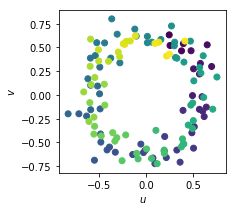

In [4]:
data = get_dataset()
# plot config
fig = plt.figure(figsize=(3, 3), facecolor='white')

u, v, dudt, dvdt, t = get_rawdata()
plt.scatter(u,v,c=t)
plt.xlabel("$u$")
plt.ylabel("$v$")
plt.show()

##### With respect to t

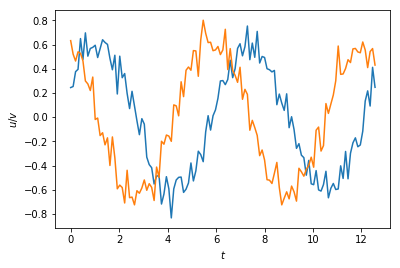

In [5]:
plt.plot(t,u,label='u')
plt.plot(t,v,label='v')
plt.xlabel("$t$")
plt.ylabel("$u/v$")
plt.show()

### Construct Models

In [6]:
def get_model(args, baseline):
    output_dim = 2
    nn_model = BaseNN(args.input_dim, args.hidden_dim, output_dim)
    model = ECNN( args.input_dim, nn_model, baseline )
    naming = '-baseline' if baseline else ''
    path = 'dynamics{}.tar'.format(naming)
    model.load_state_dict(torch.load(path))
    return nn_model

### Integrate Model

In [7]:
def integrate_model(model, t_span, uv0, **kwargs):
    damping = kwargs.pop('damping', 0)
    def fun(t, uv_in):
        scale = np.exp( - t * damping)
        uv = torch.tensor( uv_in, requires_grad=True, dtype=torch.float32 ).view(1,2)
        duv = model.forward(uv).data.numpy().reshape(-1)
        duv[0] = duv[0] * scale
        return duv
    return solve_ivp(fun=fun, t_span=t_span, y0=uv0, **kwargs)

### Analysis

In [8]:
base_model = get_model(args, True)
ecnn_model = get_model(args, False)
t_span = [0,300]
uv0 = np.array([1.0, 0.])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 20000), 'rtol': 1e-12, 'damping':0.02}
base_ivp = integrate_model( base_model, t_span, uv0, **kwargs )
ecnn_ivp = integrate_model( ecnn_model, t_span, uv0, **kwargs )

In [9]:
def forward(data):
    test_uv = torch.tensor(data, requires_grad=True,dtype=torch.float32).view(1,2)
    return ecnn_model.forward(test_uv).data
data = [0.9, 0.2]
print(forward(data))
print(forward([v*0.9 for v in data]) )

tensor([[ 0.2063, -0.9117]])
tensor([[ 0.1862, -0.8216]])


### Plot results

Text(0.5, 1.0, 'Base NN')

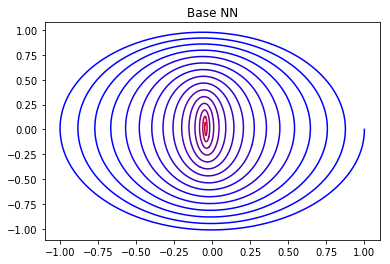

In [10]:
fig = plt.figure()
# print(base_ivp)
LINE_SEGMENTS = 10
for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color)
plt.title('Base NN')

Text(0.5, 1.0, 'Base NN')

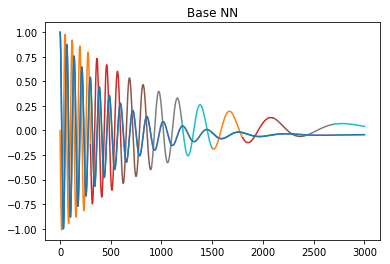

In [12]:
fig = plt.figure()
# print(base_ivp)
LINE_SEGMENTS = 10
base_v = []
for i, l in enumerate(np.split(base_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    tt = np.linspace(0, t_span[1], len(l[:,0])) + t_span[1] * i
    base_v = np.concatenate((base_v, l[:,0]))
    plt.plot(tt,l[:,0],label='0')
    plt.plot(tt,l[:,1],label='1')
base_t = np.linspace(0, t_span[1]*LINE_SEGMENTS, len(base_v))
plt.plot(base_t, base_v, label='all')
plt.title('Base NN')

In [ ]:
fig = plt.figure()
# print(base_ivp)
LINE_SEGMENTS = 10
for i, l in enumerate(np.split(ecnn_ivp['y'].T, LINE_SEGMENTS)):
    color = (float(i)/LINE_SEGMENTS, 0, 1-float(i)/LINE_SEGMENTS)
    plt.plot(l[:,0],l[:,1],color=color)
plt.title('ECNN')

In [ ]:
fig = plt.figure()
# print(base_ivp)
LINE_SEGMENTS = 10
for i, l in enumerate(np.split(ecnn_ivp['y'].T, LINE_SEGMENTS)):
    tt = np.linspace(0, t_span[1], len(l[:,0])) + t_span[1] * i
    plt.plot(tt,l[:,0],label='0')
#     plt.plot(tt,l[:,1],label='1')
plt.title('ECNN')